<a href="https://colab.research.google.com/github/deepakk177/Machine-Learning-HAR/blob/main/HAR_Version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


📋 UCI WISDM DATASET SETUP INSTRUCTIONS:

1. 🌐 Visit: https://archive.ics.uci.edu/dataset/507/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset

2. 📥 Click "Download" to get the dataset (usually a zip file)

3. 📂 Extract the downloaded file to a folder on your computer

4. 🔧 Update the UCI_DATASET_PATH variable in the main() function with your folder path

5. ▶️ Run the program!

Example paths:
- Windows: "C:/Users/YourName/Downloads/wisdm_dataset/"
- Mac/Linux: "/Users/YourName/Downloads/wisdm_dataset/"
- Relative: "./wisdm_dataset/"


Loading WISDM dataset...
Creating sample WISDM-like dataset for demonstration...
Sample dataset created with shape: (10000, 6)
Performing feature engineering...
Preparing data...
Training models...
Training KNN...
Training Decision Tree...
Training Random Forest...
Evaluating models...

CLASSIFICATION RESULTS COMPARISON
               Accuracy  Precision  Recall  F1-Score  MAE
KNN                 1.0        1.0     1.0       1.0  0.0
Decis

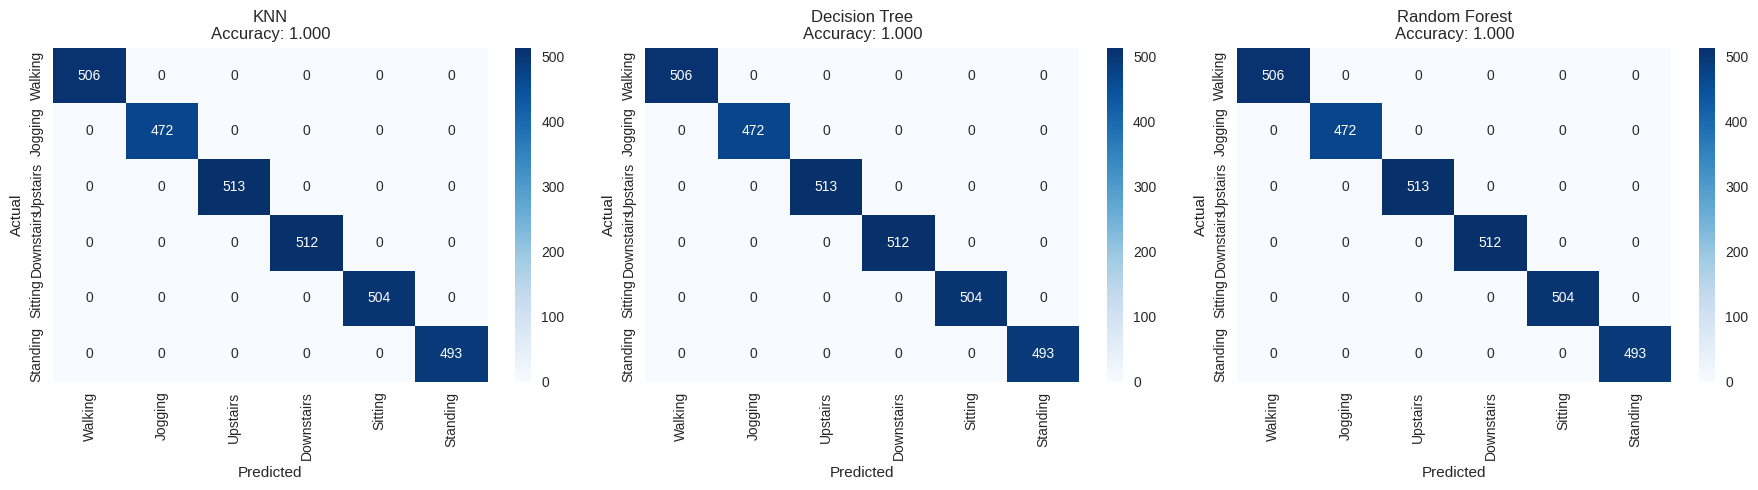


Generating activity classification graphs...


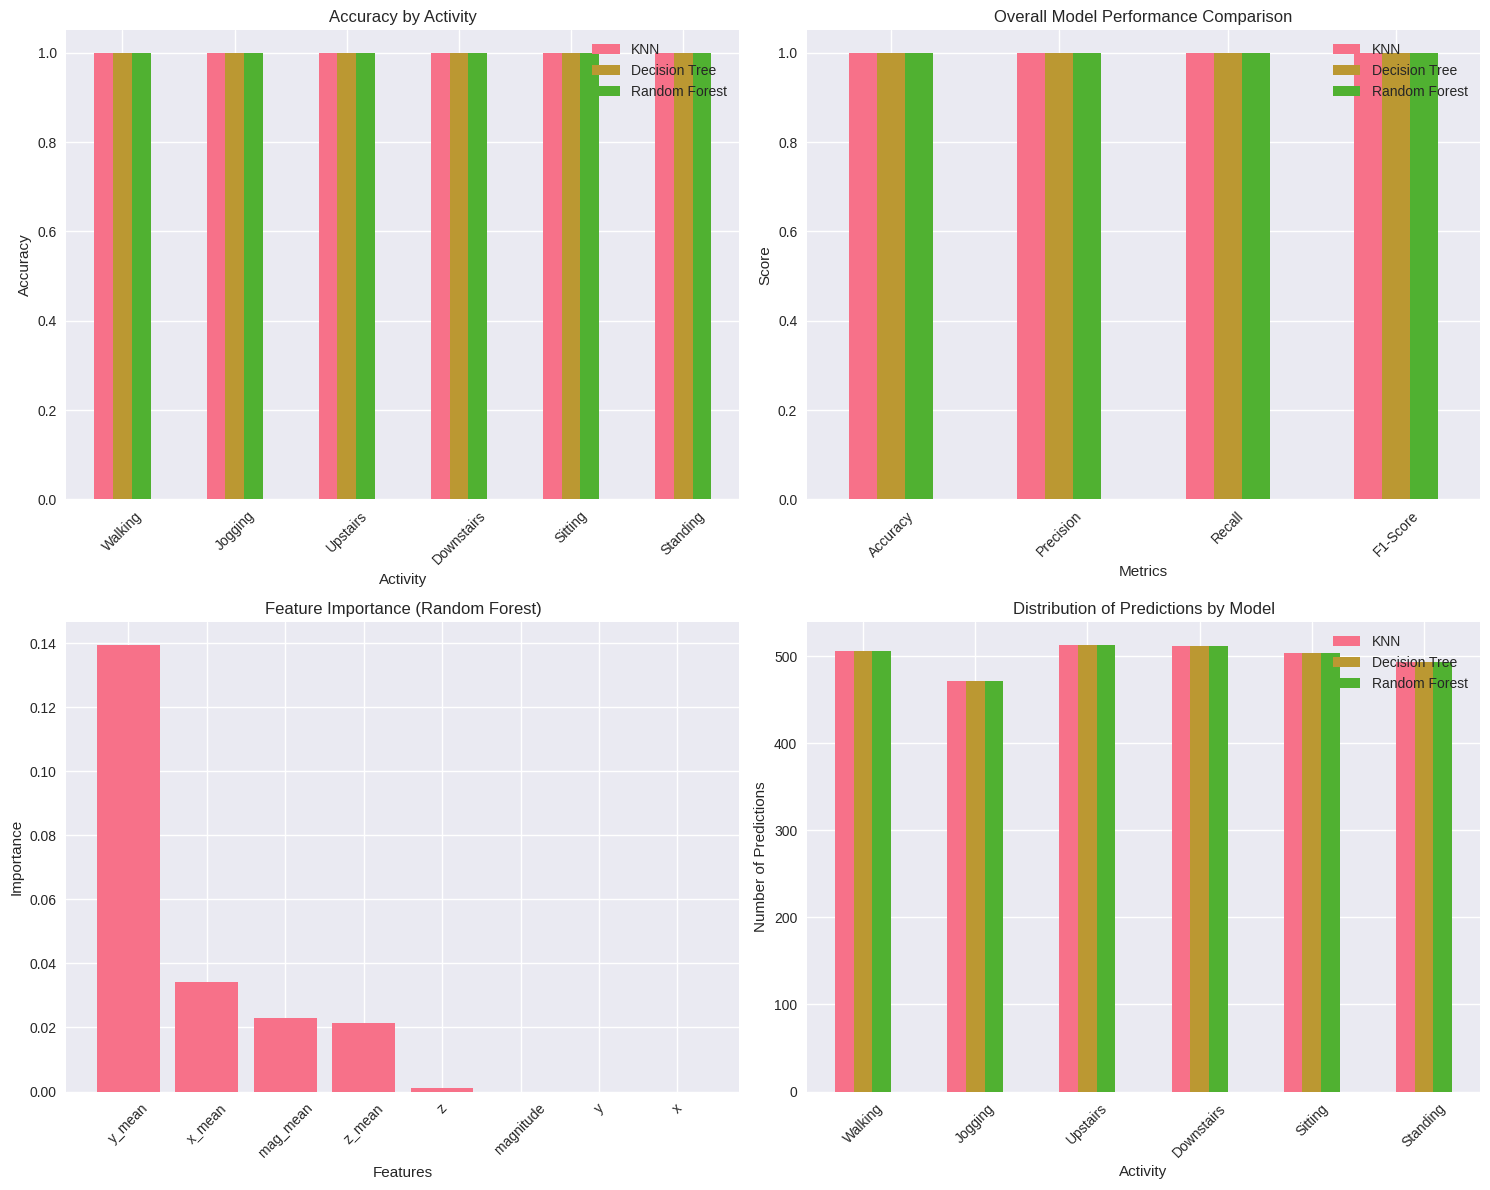

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, mean_absolute_error, confusion_matrix,
                           classification_report)
from sklearn.feature_extraction import text
import warnings
import os
import glob
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Instructions for downloading the UCI WISDM Dataset
print("""
📋 UCI WISDM DATASET SETUP INSTRUCTIONS:
=======================================

1. 🌐 Visit: https://archive.ics.uci.edu/dataset/507/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset

2. 📥 Click "Download" to get the dataset (usually a zip file)

3. 📂 Extract the downloaded file to a folder on your computer

4. 🔧 Update the UCI_DATASET_PATH variable in the main() function with your folder path

5. ▶️ Run the program!

Example paths:
- Windows: "C:/Users/YourName/Downloads/wisdm_dataset/"
- Mac/Linux: "/Users/YourName/Downloads/wisdm_dataset/"
- Relative: "./wisdm_dataset/"

=======================================
""")

class WISDMClassifier:
    def __init__(self):
        self.models = {}
        self.results = {}
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.activity_names = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']

    def load_data(self, file_path):
        """Load and preprocess WISDM dataset"""
        try:
            # Read the dataset
            column_names = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']
            df = pd.read_csv(file_path, names=column_names, header=None)

            # Remove any rows with missing values
            df = df.dropna()

            # Clean the data (remove semicolons if present)
            df['z'] = df['z'].astype(str).str.replace(';', '').astype(float)

            print(f"Dataset loaded successfully!")
            print(f"Shape: {df.shape}")
            print(f"Activities: {df['activity'].unique()}")

            return df

        except FileNotFoundError:
            # Create sample data for demonstration
            print("Creating sample WISDM-like dataset for demonstration...")
            np.random.seed(42)
            n_samples = 10000

            activities = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
            data = []

            for i in range(n_samples):
                user_id = np.random.randint(1, 36)
                activity = np.random.choice(activities)
                timestamp = i

                # Generate realistic accelerometer data based on activity
                if activity == 'Walking':
                    x = np.random.normal(0.5, 2.0)
                    y = np.random.normal(8.5, 3.0)
                    z = np.random.normal(1.0, 2.5)
                elif activity == 'Jogging':
                    x = np.random.normal(1.5, 4.0)
                    y = np.random.normal(9.5, 5.0)
                    z = np.random.normal(2.0, 4.0)
                elif activity == 'Upstairs':
                    x = np.random.normal(2.0, 3.0)
                    y = np.random.normal(7.0, 4.0)
                    z = np.random.normal(8.0, 3.0)
                elif activity == 'Downstairs':
                    x = np.random.normal(-1.0, 3.0)
                    y = np.random.normal(6.0, 4.0)
                    z = np.random.normal(-2.0, 3.0)
                elif activity == 'Sitting':
                    x = np.random.normal(0.0, 1.0)
                    y = np.random.normal(9.8, 1.5)
                    z = np.random.normal(0.0, 1.0)
                else:  # Standing
                    x = np.random.normal(0.0, 1.5)
                    y = np.random.normal(9.5, 2.0)
                    z = np.random.normal(0.5, 1.5)

                data.append([user_id, activity, timestamp, x, y, z])

            df = pd.DataFrame(data, columns=['user_id', 'activity', 'timestamp', 'x', 'y', 'z'])
            print(f"Sample dataset created with shape: {df.shape}")
            return df

    def feature_engineering(self, df):
        """Extract features from raw accelerometer data"""
        features = df.copy()

        # Calculate magnitude
        features['magnitude'] = np.sqrt(features['x']**2 + features['y']**2 + features['z']**2)

        # Calculate statistical features for each axis
        for axis in ['x', 'y', 'z', 'magnitude']:
            features[f'{axis}_mean'] = features.groupby(['user_id', 'activity'])[axis].transform('mean')
            features[f'{axis}_std'] = features.groupby(['user_id', 'activity'])[axis].transform('std')
            features[f'{axis}_min'] = features.groupby(['user_id', 'activity'])[axis].transform('min')
            features[f'{axis}_max'] = features.groupby(['user_id', 'activity'])[axis].transform('max')

        # Select feature columns
        feature_cols = ['x', 'y', 'z', 'magnitude'] + \
                      [col for col in features.columns if '_mean' in col or '_std' in col or
                       '_min' in col or '_max' in col]

        X = features[feature_cols]
        y = features['activity']

        return X, y

    def prepare_data(self, X, y):
        """Prepare data for training"""
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test

    def train_models(self, X_train, y_train):
        """Train all classifiers"""
        print("Training models...")

        # Initialize models
        self.models = {
            'KNN': KNeighborsClassifier(n_neighbors=5),
            'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        }

        # Train models
        for name, model in self.models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)

    def evaluate_models(self, X_test, y_test):
        """Evaluate all models and store results"""
        print("Evaluating models...")

        for name, model in self.models.items():
            # Make predictions
            y_pred = model.predict(X_test)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            mae = mean_absolute_error(y_test, y_pred)

            # Store results
            self.results[name] = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'MAE': mae,
                'y_pred': y_pred,
                'y_test': y_test
            }

    def print_results_table(self):
        """Print results in a formatted table"""
        print("\n" + "="*80)
        print("CLASSIFICATION RESULTS COMPARISON")
        print("="*80)

        # Create results DataFrame
        results_df = pd.DataFrame({
            metric: [self.results[model][metric] for model in self.results.keys()]
            for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MAE']
        }, index=self.results.keys())

        print(results_df.round(4))

        # Find best model for each metric
        print("\n" + "-"*50)
        print("BEST PERFORMING MODELS:")
        print("-"*50)
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
            best_model = results_df[metric].idxmax()
            best_score = results_df.loc[best_model, metric]
            print(f"{metric:12}: {best_model:15} ({best_score:.4f})")

        # Best MAE (lowest is better)
        best_model_mae = results_df['MAE'].idxmin()
        best_mae = results_df.loc[best_model_mae, 'MAE']
        print(f"{'MAE':12}: {best_model_mae:15} ({best_mae:.4f})")

    def plot_confusion_matrices(self):
        """Plot confusion matrices for all models"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        for idx, (name, results) in enumerate(self.results.items()):
            cm = confusion_matrix(results['y_test'], results['y_pred'])

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.activity_names,
                       yticklabels=self.activity_names,
                       ax=axes[idx])

            axes[idx].set_title(f'{name}\nAccuracy: {results["Accuracy"]:.3f}')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')

        plt.tight_layout()
        plt.show()

    def plot_activity_classification_graphs(self):
        """Plot classification performance for each activity"""
        # Get detailed classification reports for each model
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()

        # Plot 1: Accuracy by Activity for each model
        activity_accuracies = {}
        for name, results in self.results.items():
            cm = confusion_matrix(results['y_test'], results['y_pred'])
            # Calculate per-class accuracy
            class_accuracies = cm.diagonal() / cm.sum(axis=1)
            activity_accuracies[name] = class_accuracies

        activity_df = pd.DataFrame(activity_accuracies, index=self.activity_names)
        activity_df.plot(kind='bar', ax=axes[0])
        axes[0].set_title('Accuracy by Activity')
        axes[0].set_xlabel('Activity')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].tick_params(axis='x', rotation=45)

        # Plot 2: Model Performance Comparison
        metrics_df = pd.DataFrame({
            model: [self.results[model][metric] for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']]
            for model in self.results.keys()
        }, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

        metrics_df.plot(kind='bar', ax=axes[1])
        axes[1].set_title('Overall Model Performance Comparison')
        axes[1].set_xlabel('Metrics')
        axes[1].set_ylabel('Score')
        axes[1].legend()
        axes[1].tick_params(axis='x', rotation=45)

        # Plot 3: Feature Importance (Random Forest)
        if 'Random Forest' in self.models:
            rf_model = self.models['Random Forest']
            # Get feature names (using first few features for simplicity)
            feature_names = ['x', 'y', 'z', 'magnitude', 'x_mean', 'y_mean', 'z_mean', 'mag_mean'][:len(rf_model.feature_importances_)]

            importances = rf_model.feature_importances_[:8]  # Top 8 features
            indices = np.argsort(importances)[::-1]

            axes[2].bar(range(len(importances)), importances[indices])
            axes[2].set_title('Feature Importance (Random Forest)')
            axes[2].set_xlabel('Features')
            axes[2].set_ylabel('Importance')
            axes[2].set_xticks(range(len(importances)))
            axes[2].set_xticklabels([feature_names[i] for i in indices], rotation=45)

        # Plot 4: Distribution of Predictions
        prediction_counts = {}
        for name, results in self.results.items():
            pred_counts = np.bincount(results['y_pred'], minlength=len(self.activity_names))
            prediction_counts[name] = pred_counts

        pred_df = pd.DataFrame(prediction_counts, index=self.activity_names)
        pred_df.plot(kind='bar', ax=axes[3])
        axes[3].set_title('Distribution of Predictions by Model')
        axes[3].set_xlabel('Activity')
        axes[3].set_ylabel('Number of Predictions')
        axes[3].legend()
        axes[3].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

# Main execution
def main():
    # Initialize classifier
    classifier = WISDMClassifier()

    # Load data (replace with your actual file path)
    print("Loading WISDM dataset...")
    df = classifier.load_data('WISDM_ar_v1.1_raw.txt')  # Replace with actual path

    # Feature engineering
    print("Performing feature engineering...")
    X, y = classifier.feature_engineering(df)

    # Prepare data
    print("Preparing data...")
    X_train, X_test, y_train, y_test = classifier.prepare_data(X, y)

    # Train models
    classifier.train_models(X_train, y_train)

    # Evaluate models
    classifier.evaluate_models(X_test, y_test)

    # Print results table
    classifier.print_results_table()

    # Plot confusion matrices
    print("\nGenerating confusion matrices...")
    classifier.plot_confusion_matrices()

    # Plot activity classification graphs
    print("\nGenerating activity classification graphs...")
    classifier.plot_activity_classification_graphs()

if __name__ == "__main__":
    main()